In [13]:
import numpy as np
import nibabel as nib
from tqdm import tqdm
import os

id = '502'
name = 'MRI'

if not os.path.exists('./nnUNet/nnUNet_raw/Dataset{}_{}'.format(id, name)):
    os.mkdir('./nnUNet/nnUNet_raw/Dataset{}_{}'.format(id, name))
    os.mkdir('./nnUNet/nnUNet_raw/Dataset{}_{}/imagesTr'.format(id, name))
    os.mkdir('./nnUNet/nnUNet_raw/Dataset{}_{}/labelsTr'.format(id, name))
    os.mkdir('./nnUNet/nnUNet_raw/Dataset{}_{}/imagesTs'.format(id, name))
    os.mkdir('./nnUNet/nnUNet_raw/Dataset{}_{}/labelsTs'.format(id, name))


# loading data
baseline = np.load('./data/second_stage_dataset_192x192_100_train.npy')
sbldm = np.load('./samples/sbldm_1000/samples.npy')

baseline = np.concatenate([baseline, sbldm], axis=0)
train_volumes, train_masks = baseline[:, 0, None], baseline[:, 1, None]
train_masks = np.where(train_masks == -1, 0, train_masks)
print('(Sanity check) Train uniques in mask: {}'.format(np.unique(train_masks)))

test = np.load('./data/second_stage_dataset_192x192_100_eval.npy')
test_volumes, test_masks = test[:, 0, None], test[:, 1, None]
test_masks = np.where(test_masks == -1, 0, test_masks)
print('(Sanity check) Test uniques in mask: {}'.format(np.unique(test_masks)))

for idx in tqdm(range(train_volumes.shape[0]), position=0, leave=True, desc='Creating training set'):
    volume, mask = train_volumes[idx, 0], train_masks[idx, 0] # 192, 192, 96
    nib.save(
        nib.Nifti1Image(volume, np.eye(4)), './nnUNet/nnUNet_raw/Dataset{}_{}/imagesTr/MRI_{}_0000.nii.gz'.format(
            id, name, str(idx).zfill(3)
        )
    )
    nib.save(
        nib.Nifti1Image(mask, np.eye(4)), './nnUNet/nnUNet_raw/Dataset{}_{}/labelsTr/MRI_{}.nii.gz'.format(
            id, name, str(idx).zfill(3)
        )
    )

for idx in tqdm(range(test_volumes.shape[0]), position=0, leave=True, desc='Creating test set'):
    volume, mask = test_volumes[idx, 0], test_masks[idx, 0] # 192, 192, 96
    nib.save(
        nib.Nifti1Image(volume, np.eye(4)), './nnUNet/nnUNet_raw/Dataset{}_{}/imagesTs/MRI_{}_0000.nii.gz'.format(
            id, name, str(idx + train_volumes.shape[0]).zfill(3)
        )
    )
    nib.save(
        nib.Nifti1Image(mask, np.eye(4)), './nnUNet/nnUNet_raw/Dataset{}_{}/labelsTs/MRI_{}.nii.gz'.format(
            id, name, str(idx + train_volumes.shape[0]).zfill(3)
        )
    )

print('Done!')

(Sanity check) Train uniques in mask: [0. 1.]
(Sanity check) Test uniques in mask: [0. 1.]


Creating test set: 100%|██████████| 100/100 [00:29<00:00,  3.35it/s]

Done!


In [10]:
t = np.load('./data/second_stage_dataset_192x192_100_eval.npy')

volumes, masks = t[:, 0, None], t[:, 1, None]
masks = np.where(masks == -1, 0, masks)
print(volumes.shape, volumes.max(), volumes.min())

for idx in tqdm(range(volumes.shape[0]), position=0, leave=True):
    volume, mask = volumes[idx, 0], masks[idx, 0] # 192, 192, 96
    nib.save(nib.Nifti1Image(volume, np.eye(4)), './nnUNet_raw/Dataset501_MRI/imagesTs/MRI_{}_0000.nii.gz'.format(str(idx + 100).zfill(3)))
    nib.save(nib.Nifti1Image(mask, np.eye(4)), './nnUNet_raw/Dataset501_MRI/labelsTs/MRI_{}.nii.gz'.format(str(idx + 100).zfill(3)))


(100, 1, 192, 192, 96) 1.0 -1.0


100%|██████████| 100/100 [00:30<00:00,  3.27it/s]


In [1]:
import torch
from train_segmentation import dice_coeff, dice_loss
from train_segmentation import UNet

model = UNet(1, 1, True).to('cuda')

y = torch.randint(low=0, high=2, size=(2, 1, 192, 192, 96)).to('cuda', dtype=torch.float32)
x = torch.randn(2, 1, 192, 192, 96).to('cuda', dtype=torch.float32)

y_hat = model(x)
loss = dice_loss(torch.sigmoid(y_hat).round(), y.float())
loss

tensor(0.7346, device='cuda:0', grad_fn=<RsubBackward1>)

In [12]:
import torch
x = torch.randint(low=-1, high=2, size=(2, 2, 4, 4))
x.unique(), (x == 1).sum()

(tensor([-1,  0,  1]), tensor(16))

In [13]:
x = torch.where(x == -1, 0, x)
x.unique(), (x == 1).sum()

(tensor([0, 1]), tensor(16))

In [34]:
import torch
from modules.data import BRATSDataModule

datamodule = BRATSDataModule(
    data_dir        = './data/second_stage_dataset_192x192_200.npy',
    train_ratio     = 0.5,
    norm            = 'centered-norm', 
    batch_size      = 2,
    num_workers     = 6,
    shuffle         = True,
    # horizontal_flip = 0.5,
    # vertical_flip   = 0.5,
    # rotation        = (0, 90),
    # random_crop_size = (96, 96),
    dtype           = torch.float32,
    include_radiomics = False
)

datamodule.prepare_data()
datamodule.setup()

train_dataset = datamodule.train_dataloader().dataset.data
val_dataset = datamodule.val_dataloader().dataset.data


        DataModule setup complete.
        Number of training samples: 100
        Number of validation samples: 100
        Data shape: torch.Size([200, 2, 192, 192, 96])
        Maximum: 1.0, Minimum: -1.0
        


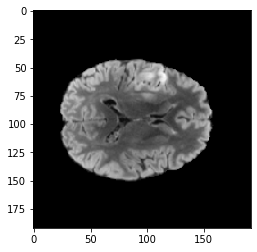

In [38]:
import matplotlib.pyplot as plt

plt.imshow(train_dataset[0][0, 0, :, :, 48], cmap='gray')

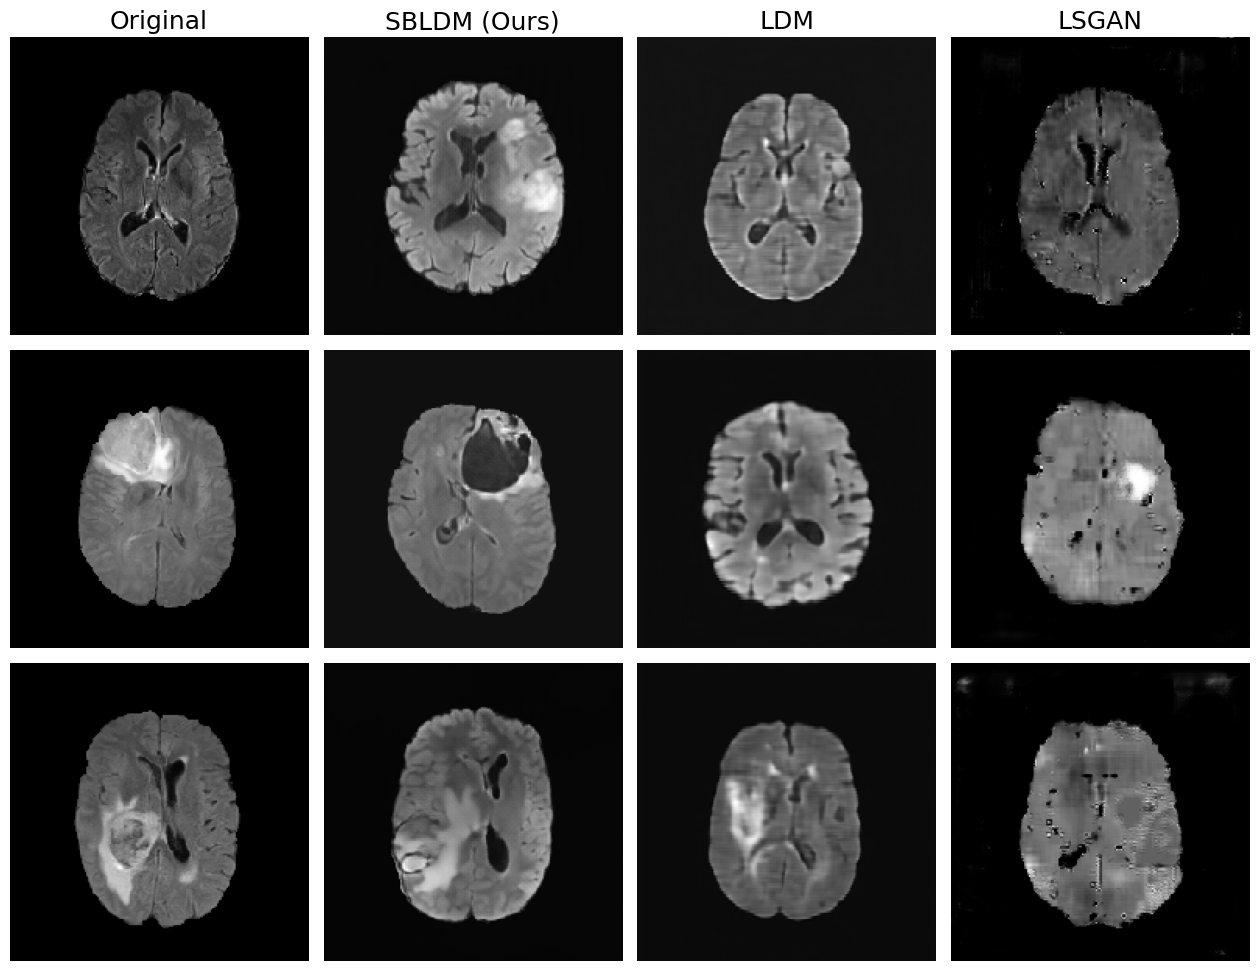

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

real = np.load('./data/second_stage_dataset_192x192_100.npy')[[11, 18, 64], 0, :, :, 48]
sbldm = np.load('./samples/sbldm_1000/samples.npy')[[0, 6, 20], 0, :, :, 48]
ldm = np.load('./samples/ldm/samples.npy')[[3, 7, 24], 0, :, :, 48]

# Define the path to the folder containing the images
folder_path = "./figures/"

# Create an empty list to store the images
images = []
# Loop through all the files in the folder
for filename in os.listdir(folder_path):
    # Check if the file is a png file
    if filename.endswith(".png"):
        # Load the image as a numpy array and convert to grayscale
        image = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
        # Append the image to the list
        images.append(image)

images = np.array(images)
lsgan = images[:, 0:images.shape[1] // 2, 192 * 12:192 * 13]

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))

# Add the method names on top of each column using LaTeX
axs[0, 0].set_title(r'Original', fontsize=18)
axs[0, 1].set_title(r'SBLDM (Ours)', fontsize=18)
axs[0, 2].set_title(r'LDM', fontsize=18)
axs[0, 3].set_title(r'LSGAN', fontsize=18)

for i in range(3):
    axs[i, 0].imshow(np.flip(real[i].T), cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(np.flip(sbldm[i].T), cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 2].imshow(np.flip(ldm[i].T), cmap='gray')
    axs[i, 2].axis('off')
    axs[i, 3].imshow(np.flip(lsgan[i].T), cmap='gray')
    axs[i, 3].axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Save the figure as SVG and PNG files in the /figures/ folder
fig.savefig('./figures/methods_comparison.svg', format='svg', bbox_inches='tight')
fig.savefig('./figures/methods_comparison.png', format='png', bbox_inches='tight')

plt.show()

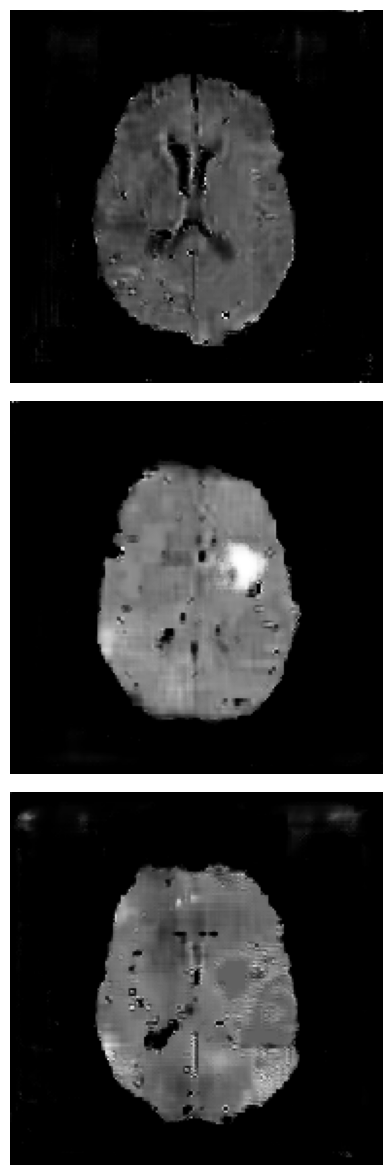

In [28]:

plt.figure(figsize=(5, 15))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.imshow(np.flip(images[i].T), cmap='gray')
    plt.axis('off')

plt.subplots_adjust(hspace=0.05)
plt.show()

In [1]:
from modules.models.embedders.latent_embedders import VAE
from modules.models.pipelines.diffusion_pipeline import DiffusionPipeline
from modules.data import BRATSDataModule
import torch

datamodule = BRATSDataModule(
    data_dir        = './data/second_stage_dataset_192x192_100.npy',
    train_ratio     = 1.0,
    norm            = 'centered-norm', 
    batch_size      = 2,
    num_workers     = 6,
    shuffle         = True,
    # horizontal_flip = 0.5,
    # vertical_flip   = 0.5,
    # rotation        = (0, 90),
    # random_crop_size = (96, 96),
    dtype           = torch.float32,
    include_radiomics = True
)

datamodule.prepare_data()
datamodule.setup()
loader = datamodule.train_dataloader()


latent_embedder = VAE.load_from_checkpoint('./runs/SBLDM-first-stage-2023_10_23_154159 (VAE 2D 2x24x24)/last.ckpt')
diffusion = DiffusionPipeline.load_from_checkpoint(
    './runs/SBLDM-second-stage-2023_10_29_021719/last.ckpt', 
    latent_embedder=latent_embedder,
    std_norm=0.8784011602401733
)


        DataModule setup complete.
        Number of training samples: 100
        Number of validation samples: 0
        Data shape: torch.Size([100, 2, 192, 192, 96])
        Maximum: 1.0, Minimum: -1.0
        
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]


c:\Users\aghil\miniconda3\envs\work\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\aghil\miniconda3\envs\work\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


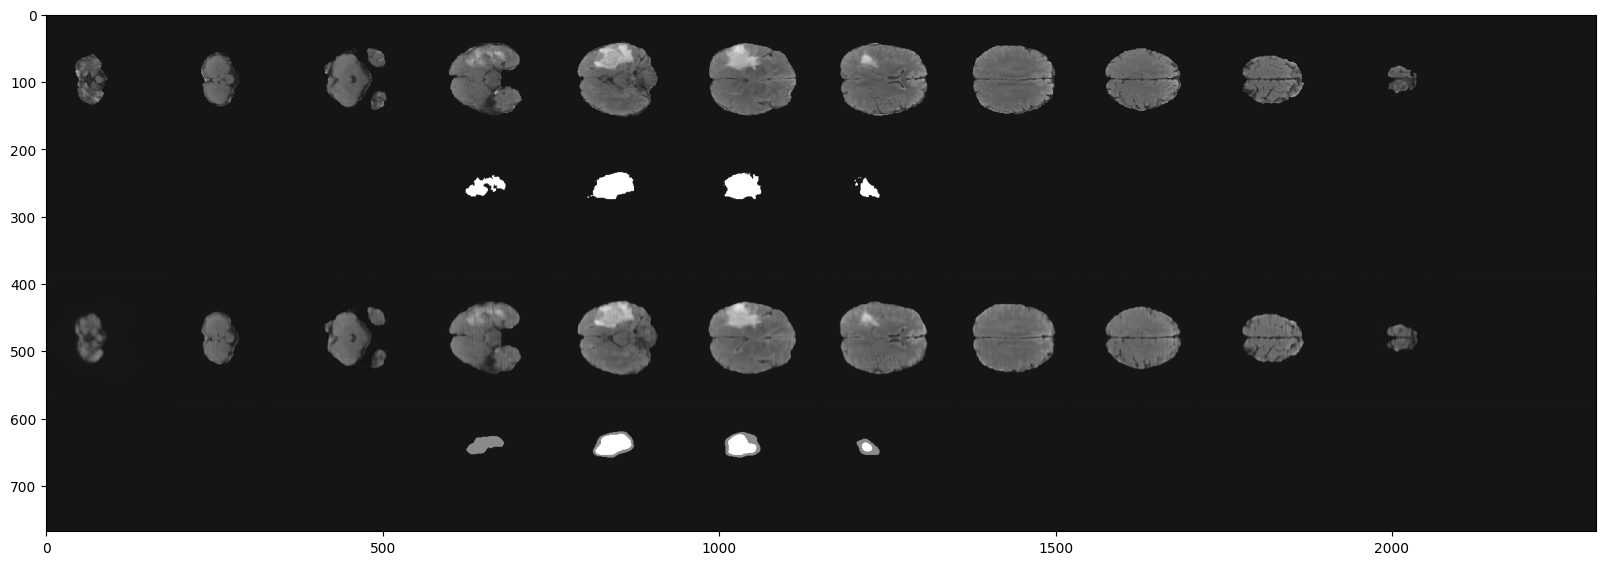

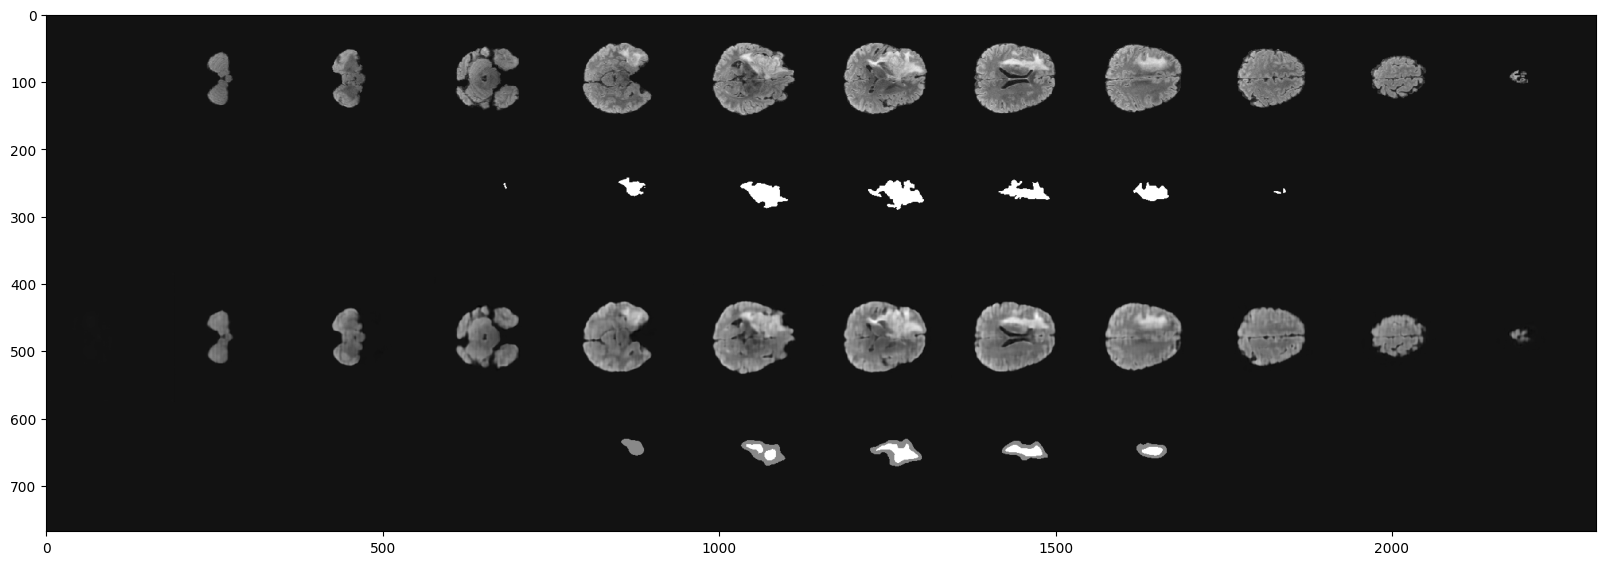

In [3]:
import matplotlib.pyplot as plt

x = x.cpu()
recon_x = recon_x[0].detach().cpu()

for s in range(x.shape[0]):
    curr_x = x[s].permute(3, 0, 1, 2)[::8, ...] # taking only 96 // 16 slices to display
    curr_x_hat = recon_x[s].permute(3, 0, 1, 2)[::8, ...]

    curr_x_hat[:, 1, ...] = curr_x_hat[:, 1, ...].round() # binarize the tumor mask
    
    originals = torch.cat([
        torch.hstack([img for img in curr_x[:, idx, ...]]) for idx in range(curr_x.shape[1])
    ], dim=0)
    
    reconstructed = torch.cat([
        torch.hstack([img for img in curr_x_hat[:, idx, ...]]) for idx in range(curr_x_hat.shape[1])
    ], dim=0)
    
    img = torch.cat([originals, reconstructed], dim=0)

    plt.figure(figsize=(20, 20))
    plt.imshow(img, cmap='gray')

In [2]:
import torch
model = model.to('cuda')
z = torch.randn(2, 2048).to('cuda')
o = model.generator(z)

/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


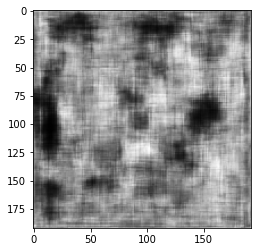

In [17]:
import matplotlib.pyplot as plt

p = o.add(1).div(2).mul(255).clamp(0, 255).to(torch.uint8)
plt.imshow(p[0, 0, :, :, 50].detach().cpu(), cmap='gray')

In [7]:
from train_lsgan import Discriminator, Generator
import torch

d = Discriminator(in_channels=2, num_channels=512).to('cuda')

x = torch.randn(2, 2, 192, 192, 96).to('cuda')

o = d(x)

In [14]:
from modules.models.embedders.latent_embedders import VAE
import torch

model = VAE(
    in_channels     = 2, 
    out_channels    = 2, 
    emb_channels    = 6,
    spatial_dims    = 3, # 2D or 3D
    hid_chs         = [64, 128, 256, 512], 
    kernel_sizes    = [3, 3, 3, 3],
    strides         = [1, 2, 2, 2],
    time_embedder   = None,
    deep_supervision = False,
    use_attention   = 'none',
    loss            = torch.nn.L1Loss,
    embedding_loss_weight = 1e-6,
    optimizer_kwargs = {'lr': 1e-5},
    perceptual_loss_weight=0.5
)

model = model.cuda()

x = torch.randn(2, 2, 192, 192, 96).cuda()
y = model.encode(x)
y.shape

Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([2, 6, 24, 24, 12])

In [13]:
from modules.models.estimators import UNet
from modules.models.embedders import TimeEmbbeding

cond_embedder = None
# cond_embedder = LabelEmbedder
cond_embedder_kwargs = {
    'in_features': 9, 
    'out_features': 512, 
    'hidden_dim': 256
}


time_embedder = TimeEmbbeding
time_embedder_kwargs = {
    'emb_dim': 512 # stable diffusion uses 4 * model_channels (model_channels is about 256)
}


noise_estimator = UNet
noise_estimator_kwargs = {
    'in_ch': 6,
    'out_ch': 6,  
    'spatial_dims': 3,
    'hid_chs': [64, 128, 256, 512],
    'kernel_sizes': [3, 3, 3, 3],
    'strides': [1, 2, 2, 2],
    'time_embedder': time_embedder,
    'time_embedder_kwargs': time_embedder_kwargs,
    'cond_embedder': cond_embedder,
    'cond_embedder_kwargs': cond_embedder_kwargs,
    'deep_supervision': False,
    'use_res_block': True,
    'use_attention': 'none',
}

unet = noise_estimator(**noise_estimator_kwargs).cuda()
x = torch.randn(2, 6, 24, 24, 12).cuda()

y = unet(x)
y[0].shape

torch.Size([2, 6, 24, 24, 12])

In [49]:
import torch
import torch.nn as nn

# x = torch.randn(2, 1, 192, 192, 96)

class ReshapeToMinus1x1(nn.Module):
    def forward(self, x):
        return x.view(-1, 1)

discriminator = nn.Sequential(
    nn.Conv3d(1, 32, kernel_size=3, stride=1, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv3d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm3d(64, affine=True),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm3d(128, affine=True),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv3d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm3d(256, affine=True),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv3d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm3d(512, affine=True),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv3d(512, 1, kernel_size=(12, 12, 6), stride=1, padding=0),
    ReshapeToMinus1x1()
)

discriminator(x)

tensor([[-0.5651],
        [ 0.0180]], grad_fn=<ViewBackward0>)

In [46]:
discriminator(x).reshape(-1, 1)

tensor([[0.0055],
        [0.6956]], grad_fn=<ReshapeAliasBackward0>)

In [3]:
import numpy as np

d = np.load('./data/second_stage_dataset_192x192_300.npy')
d.shape

(300, 2, 192, 192, 96)

In [ ]:
import torch

x = torch.randn(1, 2, 192, 192, 96).to('cuda')

In [ ]:
z = model.encode(x)
z.shape

In [10]:
from thop import clever_format
from thop import profile

input = torch.randn(1, 3, 128, 128).to('cuda')
macs, params = profile(model, inputs=(input, ))
macs, params = clever_format([macs, params], "%.3f")
macs, params

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


('595.948M', '11.690M')

In [4]:
import numpy as np
r = np.load('./data/radiomics.npy', allow_pickle=True).item()
r['x'].max()

0.7369731873111783

In [ ]:
import numpy as np
import torch

from modules.models.embedders.latent_embedders import VAE
from modules.data import BRATSDataModule

latent_embedder = VAE
latent_embedder_checkpoint = './runs/first_stage-2023_09_27_115636 (VAE 240x240 3 ch)/last.ckpt'

latent_embedder = latent_embedder.load_from_checkpoint(latent_embedder_checkpoint, time_embedder=None)
latent_embedder = latent_embedder.to('cuda')

mask_embedder = latent_embedder.load_from_checkpoint('./runs/mask-embedder-2023_09_29_140415 (VAE 240x240 1ch)/last.ckpt', time_embedder=None)
mask_embedder = mask_embedder.to('cuda')

datamodule = BRATSDataModule(
    data_dir        = './data/second_stage_dataset_240x240.npy',
    train_ratio     = 1.0,
    norm            = 'centered-norm', 
    batch_size      = 4,
    num_workers     = 6,
    shuffle         = True,
    dtype           = torch.float32
)

datamodule.prepare_data()
datamodule.setup()

batch = next(iter(datamodule.train_dataloader()))

print('start testing ...')
x_0 = batch[0]
condition = batch[1] if len(batch) > 1 else None

# Embed into latent space or normalize 
batch = []
latent_embedder.eval() 
mask_embedder.eval()
with torch.no_grad():
    for idx in range(x_0.shape[0]):
        volume = x_0[idx].permute(3, 0, 1, 2)
        images, masks = volume[:, 0, None, ...], volume[:, 1, None, ...]
        images, masks = images.to('cuda'), masks.to('cuda')
        
        images = latent_embedder.encode(images, emb=None)
        masks = mask_embedder.encode(masks, emb=None)
        volume = torch.cat((images, masks), dim=1)

        batch.append(volume)

x_0 = torch.stack(batch, dim=0)
x_0 = x_0.permute(0, 2, 1, 3, 4) # => [B, 2, 64, 16, 16]
x_0 = torch.nn.functional.pad(x_0, (1, 1, 1, 1), mode='constant', value=0)
x_0.shape

In [ ]:
import numpy
data = np.load('./data/first_stage_dataset_192x192.npy')
data.shape

In [41]:
x = torch.randn(4, 2, 192, 192).to('cuda')
o = model(x)
e = model.encode(x)
o[0].shape, e.shape

(torch.Size([4, 2, 192, 192]), torch.Size([4, 6, 24, 24]))

In [42]:
from modules.models.estimators import UNet

noise_estimator = UNet
noise_estimator_kwargs = {
    'in_ch': 1,
    'out_ch': 1,  
    'spatial_dims': 3,
    'hid_chs': [64, 128, 256, 512],
    'kernel_sizes': [3, 3, 3, 3],
    'strides': [1, 2, 2, 2],
    'deep_supervision': False,
    'use_res_block': True,
    'use_attention': 'none',
}

unet = noise_estimator(**noise_estimator_kwargs)
unet = unet.to('cuda')

In [45]:
x = torch.randn(4, 1, 96, 24, 24).to('cuda')
o = unet(x)
o[0].shape

torch.Size([4, 1, 96, 24, 24])

In [6]:
x_0 = torch.randn((1, 2, 2, 4, 4))
print(x_0[0, 0, 0, :, :])

x_0 = torch.nn.functional.pad(x_0, (1, 1, 1, 1), mode='constant', value=0)
print(x_0[0, 0, 0, :, :])

tensor([[ 0.4558,  1.2434,  1.1396,  2.0401],
        [ 0.0042, -1.8004, -0.5428, -0.8618],
        [ 0.7314,  0.4490, -1.3641, -0.0475],
        [ 1.7293,  1.0424, -0.0292,  1.4078]])
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.4558,  1.2434,  1.1396,  2.0401,  0.0000],
        [ 0.0000,  0.0042, -1.8004, -0.5428, -0.8618,  0.0000],
        [ 0.0000,  0.7314,  0.4490, -1.3641, -0.0475,  0.0000],
        [ 0.0000,  1.7293,  1.0424, -0.0292,  1.4078,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])


In [2]:
import torch

a = torch.randn(25, 25)
b = torch.normal(0, 0.68, size=(25, 25))
ab = torch.cat([a, b], dim=0)

a.std(), b.std(), ab.std(), (a.std() + b.std()) / 2

(tensor(0.9645), tensor(0.6662), tensor(0.8294), tensor(0.8153))

In [3]:
import torch

volume = data[0, 0]
volume = volume.transpose(2, 0, 1)[:, None]
volume = torch.from_numpy(volume).type(torch.float32).to('cuda')

vae.eval()
reconstructed_volume = []
for idx in range(volume.shape[0]):
    with torch.no_grad():
        reconstructed_volume.append(vae(volume[idx, None])[0].detach().cpu().numpy())

In [8]:
volume = np.concatenate(reconstructed_volume, axis=0)
volume.shape

(128, 1, 240, 240)

In [1]:
from modules.models.embedders.latent_embedders import VAEGAN
from modules.data import BRATSDataModule
import torch

# vaegan = VAEGAN.load_from_checkpoint('./runs/first_stage-2023_08_23_163957 (vae gan 2 ch)/last.ckpt', time_embedder=None)
# vaegan = vaegan.to('cuda')

datamodule = BRATSDataModule(
    data_dir        = './data/second_stage_dataset_240x240.npy',
    train_ratio     = 1.0,
    norm            = 'centered-norm',
    batch_size      = 16,
    num_workers     = 16,
    shuffle         = True,
    # random_crop_size = (96, 96),
    dtype           = torch.float32
)

datamodule.prepare_data()
datamodule.setup()
loader = datamodule.train_dataloader()

batch = next(iter(loader))


        DataModule setup complete.
        Number of training samples: 60
        Number of validation samples: 0
        Data shape: torch.Size([60, 2, 240, 240, 128])
        Maximum: 1.0, Minimum: -1.0
        


c:\Users\aghil\miniconda3\envs\work\lib\site-packages\torch\utils\data\dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [2]:
batch[0].shape

torch.Size([16, 2, 240, 240, 128])

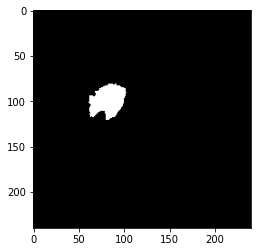

In [13]:
import matplotlib.pyplot as plt

plt.imshow(batch[0][13, 0, ...], cmap='gray')

In [1]:
import numpy as np

data = np.load('./data/brats_preprocessed.npz')
data = data['data']

In [3]:
data = data.reshape(-1, 2, 240, 240)

In [17]:
shuffle_idx = np.random.permutation(data.__len__())
shuffle_idx = shuffle_idx[:70000]
data = data[shuffle_idx]

In [6]:
data = np.load('./data/first_stage_dataset_240x240.npy')

In [10]:
np.unique(data[:, 1])

array([-1.,  1.])

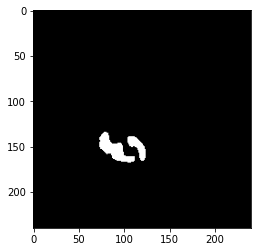

In [9]:
import matplotlib.pyplot as plt

plt.imshow(data[100, 1], cmap='gray')

In [5]:
import numpy as np

a, b = np.random.randn(16, 16, 8), np.random.randn(16, 16, 8)

c = np.stack([a, b], axis=0)
c.shape

(2, 16, 16, 8)

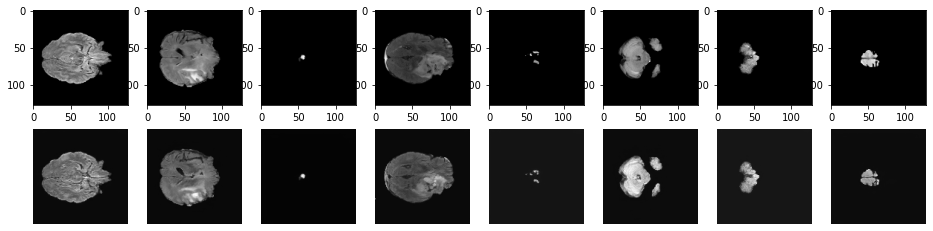

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 4))
for i in range(8):
    plt.subplot(2, 8, i + 1)
    plt.imshow(batch[i, 0, :, :].cpu().numpy(), cmap='gray')
    plt.subplot(2, 8, i + 9)
    plt.imshow(recon[i, 0, :, :].detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

In [149]:
from radiomics.firstorder import RadiomicsFirstOrder
from radiomics.shape import RadiomicsShape
from radiomics.glcm import RadiomicsGLCM
from tqdm import tqdm
import numpy as np
from scipy.ndimage import center_of_mass
from SimpleITK import GetImageFromArray
from scipy.ndimage import find_objects

def compute_bounding_box(mask):
    # find the bounding box of the binary mask
    slices = find_objects(mask.astype(np.uint8))

    # convert the slices to a tuple of (start, stop) pairs
    bbox = []
    for s in slices:
        start = (s[0].start, s[1].start, s[2].start)
        stop = (s[0].stop, s[1].stop, s[2].stop)
        bbox.append((start, stop))

    # return the bounding box
    return bbox

if __name__ == "__main__":
    data = np.load('./data/brats_preprocessed.npy')
    volumes, masks = data[:, 0, ...], data[:, 1, ...]

    # transform volume and mask to niftii without saving but just for radiomics
    radiomics = {
        'voxel_volume': [], 'surface_area': [], 'surface_volume_ratio': [], 'sphericity': [],  # shape features
        'autocorrelation': [], 'contrast': [],  # gray scale features
        'x': [], 'y': [], 'z': [], 'w': [], 'h': [], 'd': [] # position features
    }
    for idx in tqdm(range(volumes.shape[0]), position=0, leave=True):
        volume, mask = volumes[idx], masks[idx]

        # position relate features
        x, y ,z = center_of_mass(mask)
        (x_a, y_a, z_a), (x_b, y_b, z_b) = compute_bounding_box(mask)[0]
        w, h, d = x_b - x_a, y_b - y_a, z_b - z_a

        volume = GetImageFromArray(volumes[idx])
        mask = GetImageFromArray(masks[idx])

        shape_radiomics = RadiomicsShape(volume, mask)
        glcm_radiomics = RadiomicsGLCM(volume, mask)
        
        # get shape radiomics
        voxel_volume = shape_radiomics.getVoxelVolumeFeatureValue()
        surface_area = shape_radiomics.getSurfaceAreaFeatureValue()
        surface_volume_ratio = shape_radiomics.getSurfaceVolumeRatioFeatureValue()
        sphericity = shape_radiomics.getSphericityFeatureValue()

        # get glcm radiomics
        glcm_radiomics._initCalculation()
        autocorrelation = glcm_radiomics.getAutocorrelationFeatureValue()
        contrast = glcm_radiomics.getContrastFeatureValue()

        # put all together
        for feature_key, feature in zip(
            radiomics.keys(),
            [
                voxel_volume, surface_area, surface_volume_ratio, sphericity, 
                autocorrelation[0], contrast[0],
                x, y, z, w, h, d
            ]
        ):
            radiomics[feature_key].append(feature)

    # convert to numpy array
    for key in radiomics.keys():
        radiomics[key] = np.array(radiomics[key])

    # normalizing features
    radiomics['x'], radiomics['w'] = radiomics['x'] / mask.shape[0], radiomics['w'] / mask.shape[0]
    radiomics['y'], radiomics['h'] = radiomics['y'] / mask.shape[1], radiomics['h'] / mask.shape[1]
    radiomics['z'], radiomics['d'] = radiomics['z'] / mask.shape[2], radiomics['d'] / mask.shape[2]

    radiomics['voxel_volume'] = radiomics['voxel_volume'] / np.max(radiomics['voxel_volume'])
    radiomics['surface_area'] = radiomics['surface_area'] / np.max(radiomics['surface_area'])
    # surface_area_volume ratio and sphericity are already comprised between 0 and 1

    radiomics['autocorrelation'] = radiomics['autocorrelation'] / np.max(radiomics['autocorrelation'])
    radiomics['contrast'] = radiomics['contrast'] / np.max(radiomics['contrast'])
    


100%|██████████| 999/999 [03:37<00:00,  4.60it/s]


In [3]:
import numpy as np
data = np.load('./data/brats_preprocessed.npz')
data = data['data']

In [7]:
np.argmax([v.max() for v in data[:, 0, ...]])

467

In [5]:
import os
from nibabel import load

files = os.listdir('../common_data/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021')
files[467]

'BraTS2021_01163'

In [13]:
v = load('../common_data/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/BraTS2021_01163/BraTS2021_01163_flair.nii.gz').get_fdata()

In [14]:
v.max()

612366.4375

In [15]:
from tqdm import tqdm
i, max = 0, 0
for idx, f in tqdm(enumerate(files)):
    v = load(f'../common_data/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/{f}/{f}_flair.nii.gz').get_fdata()
    if v.max() > max:
        max = v.max()
        i = idx

print(i, max)

1251it [02:00, 10.37it/s]

467 612366.4375


In [ ]:
from modules.data import BRATSDataModule

datamodule = BRATSDataModule(
    data_dir     = '../common_data/RSNA_ASNR_MICCAI_BraTS2021_TrainingData_16July2021/',
    n_samples    = 1000,
    modalities   = ['flair', 'seg'],
    target_shape = (240, 240, 128),
    binarize=True,
    norm='centered-norm',
    batch_size   = 16,
    num_workers  = 16
)

datamodule.prepare_data()

In [6]:
import numpy as np
from sys import getsizeof

# display size of data in GB

print('data size: {:.2f} GB'.format(getsizeof(data) / 1e9))

data size: 117.96 GB


In [3]:
np.argmax([volume.max() for volume in data[:, 0, ...]])

467

In [5]:
for k in radiomics.keys():
    print('{}: Max {}, Min {}, Mean {}'.format(k, np.max(radiomics[k]), np.min(radiomics[k]), np.mean(radiomics[k])))

voxel_volume: Max 1.0, Min 0.008945569649287796, Mean 0.2715123316540845
surface_area: Max 1.0, Min 0.024318990019346714, Mean 0.28418457770974404
surface_volume_ratio: Max 1.084740571277526, Min 0.21527868118742113, Mean 0.41200834776115575
sphericity: Max 0.8558661053919444, Min 0.2411068155424384, Mean 0.5918284686018956
autocorrelation: Max 1.0, Min 2.372179100342089e-05, Mean 0.005827837947241071
contrast: Max 1.0, Min 3.984650567131488e-05, Mean 0.006119010836514069
x: Max 0.7361332331299354, Min 0.26596607289950575, Mean 0.4920874897352733
y: Max 0.7137472587719298, Min 0.20306892942583732, Mean 0.447867382021159
z: Max 0.8131713591135233, Min 0.16205973129992737, Mean 0.5161439914303525
w: Max 0.5390625, Min 0.078125, Mean 0.2542777152152152
h: Max 0.6875, Min 0.09375, Mean 0.34473536036036034
d: Max 0.890625, Min 0.140625, Mean 0.4251438938938939


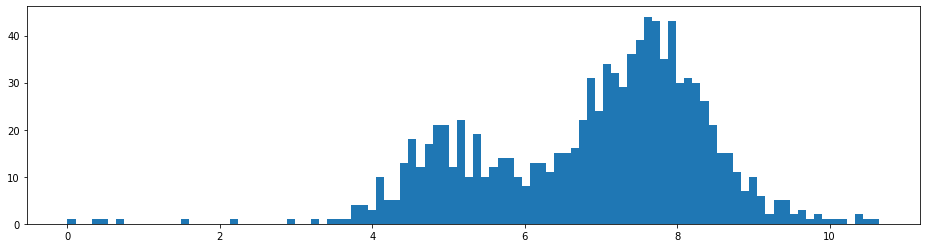

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 4))
plt.hist(-np.log(radiomics['autocorrelation']), bins=100)
plt.show()

In [ ]:
    # calculate the max, min, mean, and median values for each radiomics feature
    max_values = np.max([list(r.values()) for r in radiomics], axis=0)
    min_values = np.min([list(r.values()) for r in radiomics], axis=0, dtype=object)
    mean_values = np.mean([list(r.values()) for r in radiomics], axis=0, dtype=object)
    median_values = np.median([list(r.values()) for r in radiomics], axis=0, dtype=object)

    # create the table header
    header = '{:<20} {:<10} {:<10} {:<10} {:<10}'.format('Radiomics', 'Max', 'Min', 'Mean', 'Median')

    # create the table rows
    rows = ''
    for key in radiomics[0].keys():
        row = '{:<20} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f}'.format(
            key, 
            max_values[list(radiomics[0].keys()).index(key)], 
            min_values[list(radiomics[0].keys()).index(key)], 
            mean_values[list(radiomics[0].keys()).index(key)], 
            median_values[list(radiomics[0].keys()).index(key)]
        )
        rows += row + '\n'

    # combine the header and rows into a single string
    log = header + '\n' + rows

    print(log)
    
    # saving
    np.save('{}/radiomics.npy'.format(args.save_path), np.array(radiomics))

In [7]:
import torch
from modules.models.embedders.latent_embedders import VAE

model_3d = VAE(
    in_channels     = 1, 
    out_channels    = 1, 
    emb_channels    = 1,
    spatial_dims    = 3, # 2D or 3D
    hid_chs         = [32, 64, 128, 256], 
    kernel_sizes    = [3, 3, 3, 3],
    strides         = [1, 2, 2, 2],
    time_embedder   = None,
    deep_supervision = False,
    use_attention   = 'none', # ['none', 'none', 'none', 'spatial'],
    loss            = torch.nn.MSELoss,
    embedding_loss_weight = 1e-6,
    optimizer_kwargs = {'lr': 1e-5}
)

model_2d = VAE(
    in_channels     = 1, 
    out_channels    = 1, 
    emb_channels    = 1,
    spatial_dims    = 2, # 2D or 3D
    hid_chs         = [32, 64, 128, 256], 
    kernel_sizes    = [3, 3, 3, 3],
    strides         = [1, 2, 2, 2],
    time_embedder   = None,
    deep_supervision = False,
    use_attention   = 'none', # ['none', 'none', 'none', 'spatial'],
    loss            = torch.nn.MSELoss,
    embedding_loss_weight = 1e-6,
    optimizer_kwargs = {'lr': 1e-5}
)

model_3d = model_3d.to('cuda')
model_2d = model_2d.to('cuda')

Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]


In [11]:
import time
from tqdm import tqdm

start = time.time()

for _ in tqdm(range(1000)):
    x = torch.randn(1, 1, 128, 128, 64).to('cuda')
    x_hat, _, _ = model_3d(x)

end = time.time()

t_3d = (end - start) / 100

start = time.time()

for _ in tqdm(range(1000)):
    x = torch.randn(64, 1, 128, 128).to('cuda')
    x_hat, _, _ = model_2d(x)

end = time.time()

t_2d = (end - start) / 100

print('3D: {}s'.format(t_3d))
print('2D: {}s'.format(t_2d))

100%|██████████| 1000/1000 [00:47<00:00, 21.14it/s]

3D: 0.6204198908805847s
2D: 0.47316832780838014s


In [12]:
print('3D: {}s'.format(t_3d))
print('2D: {}s'.format(t_2d))
print('Ratio: {}'.format(t_3d / t_2d))

3D: 0.6204198908805847s
2D: 0.47316832780838014s
Ratio: 1.3112033380472525


In [19]:
import torch
from modules.models.pipelines import DiffusionPipeline
from modules.models.estimators import UNet
from modules.models.noise_schedulers import GaussianNoiseScheduler
from modules.models.embedders import TimeEmbbeding
from modules.models.embedders.latent_embedders import VAE

latent_embedder = VAE(
    in_channels     = 1, 
    out_channels    = 1, 
    emb_channels    = 1,
    spatial_dims    = 2, # 2D or 3D
    hid_chs         = [32, 64, 128, 256], 
    kernel_sizes    = [3, 3, 3, 3],
    strides         = [1, 2, 2, 2],
    time_embedder   = None,
    deep_supervision = False,
    use_attention   = 'none', # ['none', 'none', 'none', 'spatial'],
    loss            = torch.nn.MSELoss,
    embedding_loss_weight = 1e-6,
    optimizer_kwargs = {'lr': 1e-5}
).to('cuda')

cond_embedder = None 
# cond_embedder = LabelEmbedder
cond_embedder_kwargs = {
    'emb_dim': 1024,
    'num_classes': 2
}


time_embedder = TimeEmbbeding
time_embedder_kwargs ={
    'emb_dim': 1024 # stable diffusion uses 4*model_channels (model_channels is about 256)
}

noise_scheduler = GaussianNoiseScheduler
noise_scheduler_kwargs = {
    'timesteps': 1000,
    'beta_start': 0.002, # 0.0001, 0.0015
    'beta_end': 0.02, # 0.01, 0.0195
    'schedule_strategy': 'cosine'
}

noise_estimator = UNet
noise_estimator_kwargs = {
    'in_ch': 1, 
    'out_ch': 1, 
    'spatial_dims': 2,
    'hid_chs':  [256, 256, 512, 1024],
    'kernel_sizes':[3, 3, 3, 3],
    'strides':     [1, 2, 2, 2],
    'time_embedder':time_embedder,
    'time_embedder_kwargs': time_embedder_kwargs,
    'cond_embedder':cond_embedder,
    'cond_embedder_kwargs': cond_embedder_kwargs,
    'deep_supervision': False,
    'use_res_block':True,
    'use_attention':'none',
}

pipeline = DiffusionPipeline(
    noise_estimator=noise_estimator, 
    noise_estimator_kwargs=noise_estimator_kwargs,
    noise_scheduler=noise_scheduler, 
    noise_scheduler_kwargs = noise_scheduler_kwargs,
    latent_embedder=latent_embedder,
    # latent_embedder_checkpoint = latent_embedder_checkpoint,
    estimator_objective='x_T',
    estimate_variance=False, 
    use_self_conditioning=False, 
    use_ema=False,
    classifier_free_guidance_dropout=0.0, # Disable during training by setting to 0
    do_input_centering=False,
    clip_x0=False
).to('cuda')

Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]


In [21]:
import time

start = time.time()

for _ in range(10):
    sample_img = pipeline.sample(num_samples=1, img_size=(1, 128, 128), condition=None, steps=50, use_ddim=True).detach()

end = time.time()

t_3d = (end - start) / 10
print('3D: {}s'.format(t_3d))

50it [00:01, 27.68it/s]
50it [00:01, 27.83it/s]
50it [00:01, 27.66it/s]
50it [00:01, 27.71it/s]
50it [00:01, 27.72it/s]
50it [00:01, 27.85it/s]
50it [00:01, 27.64it/s]
50it [00:01, 27.46it/s]
50it [00:01, 27.48it/s]
50it [00:01, 27.55it/s]

3D: 1.8144766807556152s


In [50]:
latent_embedder = VAE
latent_embedder_checkpoint = './runs/first_stage-2023_08_11_230709 (best AE so far + mask)/epoch=489-step=807030.ckpt'

latent_embedder = latent_embedder.load_from_checkpoint(latent_embedder_checkpoint, time_embedder=None)

pipeline = DiffusionPipeline.load_from_checkpoint(
    './runs/2023_08_16_113818 (continuity)/epoch=999-step=63000.ckpt', 
    latent_embedder=latent_embedder.to('cuda'),
).to('cuda')

Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'latent_embedder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['latent_embedder'])`.
  rank_zero_warn(


300it [00:11, 26.05it/s]


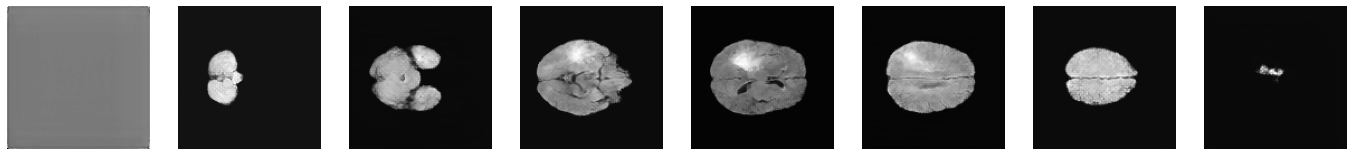

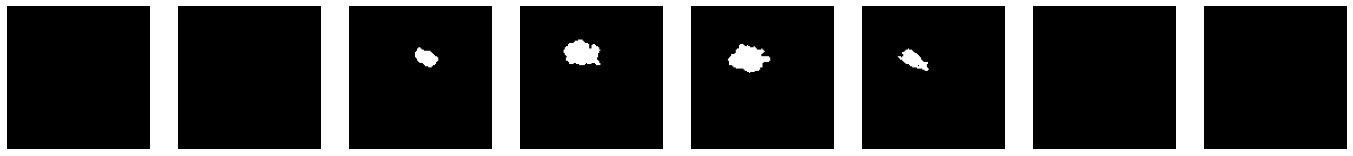

In [65]:
import matplotlib.pyplot as plt
import numpy as np

img = pipeline.sample(num_samples=1, img_size=(8, 128, 128), condition=None, use_ddim=True, steps=300).detach()
img = img.reshape(1, 8, 64, 16, 16).squeeze(0).permute(1, 0, 2, 3)
decoded_slices = latent_embedder.decode(img, emb=None).detach()

decoded_slices[:, 1] = decoded_slices[:, 1].clip_(-1, 1).add_(1).mul_(0.5).round_()

plt.figure(figsize=(24, 12))
for idx, s in enumerate(np.arange(64, step=8)):
    plt.subplot(1, 8, idx + 1)
    plt.imshow(decoded_slices[s, 0, ...].cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

plt.figure(figsize=(24, 12))
for idx, s in enumerate(np.arange(64, step=8)):
    plt.subplot(1, 8, idx + 1)
    plt.imshow(decoded_slices[s, 1, ...].cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

## --------------------------------------------------------

In [2]:
import torch
from modules.data import BRATSDataModule


dm = BRATSDataModule(
    data_dir        = './data/brats_preprocessed.npy',
    train_ratio     = 0.95,
    norm            = 'centered-norm',
    batch_size      = 8,
    num_workers     = 6,
    shuffle         = True,
    horizontal_flip = 0.5,
    vertical_flip   = 0.5,
    slice_wise      = False,
    drop_channels   = [0]
)

In [3]:
dm.setup()
loader = dm.train_dataloader()

Normalizing data: 100%|██████████| 1000/1000 [00:01<00:00, 864.73it/s]



        DataModule setup complete.
        Number of training samples: 950
        Number of validation samples: 50
        Data shape: torch.Size([1000, 1, 128, 128, 64])
        Maximum: 1.0, Minimum: -1.0
        


In [ ]:
import torch.nn as nn

class MaskReconstructionLoss(nn.Module):
    def __init__(self, alpha_dice=1.0, alpha_mse=1.0, alpha_acc=1.0):
        """
        Custom loss function for binary masks with spatial consistency loss.

        Args:
        - alpha_dice (float): Weight for Dice loss.
        - alpha_mse (float): Weight for MSE loss.
        - alpha_acc (float): Weight for accuracy loss.
        """
        super(MaskReconstructionLoss, self).__init__()
        self.alpha_dice = alpha_dice
        self.alpha_mse = alpha_mse
        self.alpha_acc = alpha_acc

    def forward(self, mask_pred, mask_target):
        """
        Forward pass of the custom loss.

        Args:
        - mask_pred (torch.Tensor): Predicted masks of shape (batch_size, 1, 128, 128, 64).
        - mask_target (torch.Tensor): Target masks of the same shape as mask_pred.

        Returns:
        - loss (torch.Tensor): Combined loss.
        """
        dims = (1, 2, 3) + ((4,) if mask_pred.dim() == 5 else ())

        # Dice Loss
        dice_loss = 1 - (2 * (mask_pred * mask_target).sum(dim=dims) + 1) / (mask_pred.sum(dim=dims) + mask_target.sum(dim=dims) + 1)

        # MSE Loss
        mse_loss = nn.functional.mse_loss(mask_pred, mask_target, reduction='none').mean(dim=dims)

        # Accuracy Loss
        acc_loss = (mask_pred == mask_target).float().mean(dim=dims)

        # Combine the losses with the specified weights
        loss = (self.alpha_dice * dice_loss) + (self.alpha_mse * mse_loss) + (self.alpha_acc * acc_loss)

        return loss
    
m = MaskReconstructionLoss(alpha_dice=0.0, alpha_mse=1.0, alpha_acc=0.0)

mask_pred = torch.bernoulli(torch.empty(8, 1, 128, 128, 64).fill_(0.3)).float()
mask_target = torch.bernoulli(torch.empty(8, 1, 128, 128, 64).fill_(0.7)).float()

m(mask_pred, mask_target)


In [4]:
from modules.models.embedders.latent_embedders import VAE

vae = VAE.load_from_checkpoint('./runs/mask-embedder-2023_09_05_161605-VAgTys/last.ckpt')
vae = vae.to('cuda')

Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
batch = next(iter(loader))

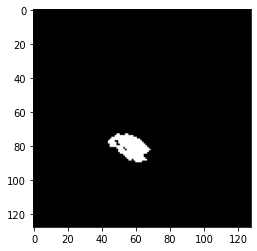

In [15]:
plt.imshow(batch[0][0, 0, :, :, 40].cpu().detach(), cmap='gray')

In [7]:
o = vae(batch[0].to('cuda'))

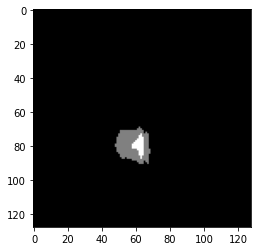

In [16]:
import matplotlib.pyplot as plt

plt.imshow(o[0][0, 0, :, :, 40].cpu().detach().round(), cmap='gray')

50it [00:01, 25.99it/s]


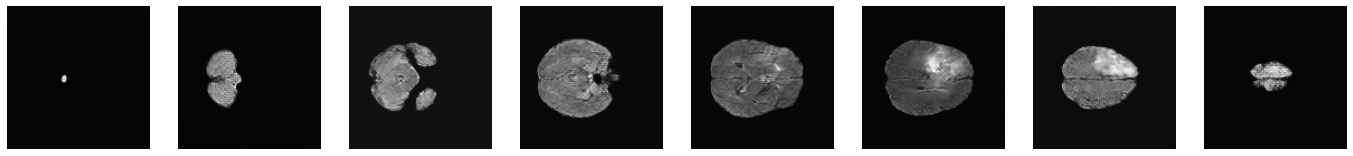

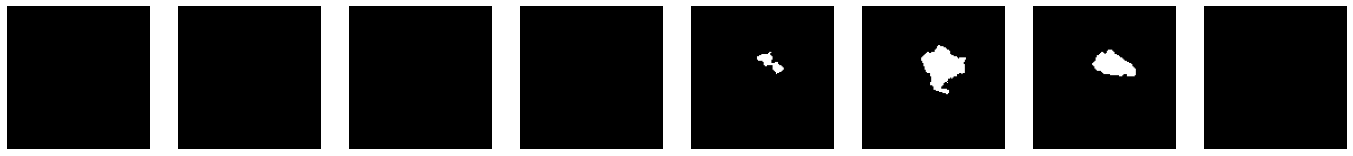

In [77]:
import matplotlib.pyplot as plt
import numpy as np

img = pipeline.sample(num_samples=1, img_size=(8, 128, 128), condition=None, use_ddim=True, steps=50).detach()
img = img.reshape(1, 8, 64, 16, 16).squeeze(0).permute(1, 0, 2, 3)
decoded_slices = latent_embedder.decode(img, emb=None).detach()

decoded_slices[:, 1] = decoded_slices[:, 1].clip_(-1, 1).add_(1).mul_(0.5).round_()

plt.figure(figsize=(24, 12))
for idx, s in enumerate(np.arange(64, step=8)):
    plt.subplot(1, 8, idx + 1)
    plt.imshow(decoded_slices[s, 0, ...].cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

plt.figure(figsize=(24, 12))
for idx, s in enumerate(np.arange(64, step=8)):
    plt.subplot(1, 8, idx + 1)
    plt.imshow(decoded_slices[s, 1, ...].cpu().numpy(), cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
import time

start = time.time()

for _ in range(10):
    sample_img = pipeline.sample(num_samples=1, img_size=(1, 64, 16, 16), condition=None).detach()

end = time.time()

t_3d = (end - start) / 10
print('3D: {}s'.format(t_3d))

In [65]:
import torch
import torch.nn.functional as F

def spatially_stack_latents(latents, grid_size, index_channel=False):
    batch_size, num_latents, num_channels, height, width = latents.size()
    latents_stacked = latents.permute(0, 2, 1, 3, 4).contiguous()  # Rearrange dimensions
    
    grid_height = grid_size[0]
    grid_width = grid_size[1]
    
    num_cols = num_latents // grid_height
    num_rows = num_latents // grid_width
    
    assert num_cols * num_rows == num_latents, "Grid size is not compatible with number of latents"

    latents_stacked = latents_stacked.view(batch_size, num_channels, num_rows, num_cols, height, width)
    latents_stacked = latents_stacked.permute(0, 1, 2, 4, 3, 5).contiguous()  # Rearrange dimensions
    latents_stacked = latents_stacked.view(batch_size, num_channels, num_rows * height, num_cols * width)

    if index_channel:
        # generating an index channel
        index_channel = torch.ones(batch_size, 1, num_rows * height, num_cols * width)
        for i in range(num_rows):
            for j in range(num_cols):
                index_channel[:, :, i * height : (i + 1) * height, j * width : (j + 1) * width] *= (i * num_cols + j)
        
        # Add index channel
        latents_stacked = torch.cat([latents_stacked, index_channel.to(latents_stacked.device)], dim=1)
    
    return latents_stacked

def reverse_spatial_stack(latents_stacked, shape, index_channel=False):
    if index_channel: # we drop the index channel
        latents_stacked = latents_stacked[:, :-1, ...]

    batch_size, num_channels, height, width = latents_stacked.size()
    orig_height, orig_width = shape
    num_cols = width // orig_width
    num_rows = height // orig_height

    latents_stacked = latents_stacked.reshape(batch_size, num_channels, num_rows, orig_height, num_cols, orig_width)
    latents_stacked = latents_stacked.permute(0, 1, 2, 4, 3, 5).contiguous()  # Rearrange dimensions
    latents_stacked = latents_stacked.reshape(batch_size, num_channels, num_rows * num_cols, orig_height, orig_width)
    
    # channels first
    latents_stacked = latents_stacked.permute(0, 2, 1, 3, 4).contiguous()  # Rearrange dimensions

    return latents_stacked

# Example usage
batch_size = 1
num_latents = 9
num_channels = 1
height = 2
width = 2
latents = torch.ones(batch_size, num_latents, num_channels, height, width)
for idx in range(num_latents):
    latents[:, idx, :, :, :] *= idx

grid_size = (3, 3)  # Grid of 4x16 latents
latents_stacked = spatially_stack_latents(latents, grid_size, index_channel=True)
reconstructed_latents = reverse_spatial_stack(latents_stacked, shape=(2, 2), index_channel=True)

print("Original Latents Shape:", latents.shape)
print("Stacked Latents Shape:", latents_stacked.shape) 
print("Reconstructed Latents Shape:", reconstructed_latents.shape)

Original Latents Shape: torch.Size([1, 9, 1, 2, 2])
Stacked Latents Shape: torch.Size([1, 2, 6, 6])
Reconstructed Latents Shape: torch.Size([1, 9, 1, 2, 2])


In [1]:
import torch
x = torch.randn(4, 2, 128, 128)
x_hat = torch.randn(4, 2, 128, 128)

originals = torch.cat([
    torch.hstack([img for img in x[:, idx, ...]])
    for idx in range(x.shape[1])
], dim=0)

reconstructed = torch.cat([
    torch.hstack([img for img in x_hat[:, idx, ...]])
    for idx in range(x_hat.shape[1])
], dim=0)

img = torch.cat([originals, reconstructed], dim=0)
img.shape

torch.Size([512, 512])

In [1]:
import numpy as np

data = np.load('./data/brats_preprocessed.npy')

In [35]:
import torch

x = torch.randint(0, 2, size=(4, 4))

x

tensor([[0, 1, 0, 0],
        [0, 1, 1, 0],
        [0, 1, 0, 1],
        [1, 1, 1, 1]])

In [5]:
from modules.models.embedders.latent_embedders import VAEGAN
import torch

model = VAEGAN(
    in_channels     = 1, 
    out_channels    = 1, 
    emb_channels    = 2,
    spatial_dims    = 2,
    hid_chs         = [64, 128, 256, 512],
    deep_supervision = False,
    use_attention   = ['none', 'none', 'none', 'spatial'],
    start_gan_train_step = -1,
    embedding_loss_weight = 1e-6,
)

Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aghiles/anaconda3/envs/work/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
o = model(torch.randn(4, 1, 128, 128))
o[1]

[]

In [2]:
import numpy as np
data = np.load('./brats_preprocessed.npy', allow_pickle=True)
data = data[:, 0, None]
data = data.transpose(0, 4, 1, 2, 3) # depth first

norm = lambda data: (2 * data - data.min() - data.max()) / (data.max() - data.min())
for idx in range(data.shape[0]):
    data[idx] = norm(data[idx]).astype(np.float32)

data = data.reshape(-1, 1, 128, 128)

print(data.shape)
print(data.max(), data.min())

(64000, 1, 128, 128)
1.0 -1.0


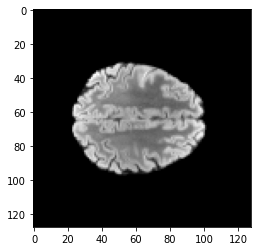

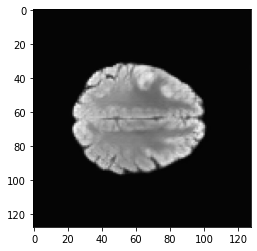

In [31]:
import matplotlib.pyplot as plt

idx = 300

# original
plt.imshow(data[idx, 0, :, :], cmap='gray')
plt.show()

import torch

x = torch.from_numpy(data[idx, None, :, :, :]).to('cuda', torch.float32)
recon, _, _ = vae(x)
plt.imshow(recon[0, 0].detach().cpu().numpy(), cmap='gray')

In [2]:
import torch
import numpy as np

from medical_diffusion.models.embedders.latent_embedders import VAE
from medical_diffusion.data.datamodules import SimpleDataModule

class IdentityDataset(torch.utils.data.Dataset):
    def __init__(self, *data):
        self.data = data

    def __len__(self):
        return self.data[-1].__len__()

    def __getitem__(self, index):
        return [d[index] for d in self.data]

: 

: 

In [1]:
import pytorch_lightning.utilities.cloud_io as plcloud

In [10]:
data = np.load('./brats_preprocessed.npy', allow_pickle=True)
data = data[:, 0, None, ..., 32]

norm = lambda data: (2 * data - data.min() - data.max()) / (data.max() - data.min())
for idx in range(data.shape[0]):
    data[idx] = norm(data[idx]).astype(np.float32)

dataset = IdentityDataset(data)

dm = SimpleDataModule(
    ds_train = dataset,
    batch_size=8, 
    num_workers=0,
    pin_memory=False
) 

In [17]:
import pytorch_lightning as pl

In [11]:
dm.prepare_data()
dm.setup(stage='train')

In [12]:
loader = dm.train_dataloader()

In [13]:
b = next(iter(loader))

\begin{table}[t]
\footnotesize
\centering
\resizebox{\columnwidth}{!}{%
\begin{tabular}{@{}clccccc@{}}
\toprule
\multicolumn{2}{c}{\multirow{2}{*}{Methods}} & \multicolumn{5}{c}{Number of training volumes} \\ \cmidrule(l){3-7} 
                         &                         & 10 & 20 & 30 & 40 & 50 \\ \cmidrule(r){1-2} \cmidrule(lr){3-3} \cmidrule(lr){4-4} \cmidrule(lr){5-5} \cmidrule(lr){6-6} \cmidrule(l){7-7}
\multirow{3}{*}{BRATS}   & Reference               & 0.604$\pm$0.07 & 0.620$\pm$0.06 & 0.663$\pm$0.04 & 0.672$\pm$0.05 & 0.703$\pm$0.01 \\
                         & Ours ($\alpha = 0.01$)  & 0.790$\pm$0.01 & 0.818$\pm$0.01 & 0.842$\pm$0.01 & 0.808$\pm$0.02 & 0.821$\pm$0.01 \\ 
                         & Ours + Aug. ($\times$5) & \textbf{0.799$\pm$0.02} & \textbf{0.828$\pm$0.01} & \textbf{0.845$\pm$0.01} & \textbf{0.822$\pm$0.03} & \textbf{0.840$\pm$0.03} \\ \cmidrule(r){1-2} \cmidrule(lr){3-3} \cmidrule(lr){4-4} \cmidrule(lr){5-5} \cmidrule(lr){6-6} \cmidrule(l){7-7}
\multirow{3}{*}{HECKTOR} & Reference               & 0.454$\pm$0.11  & 0.528$\pm$0.10  & 0.542$\pm$0.02  & 0.629$\pm$0.04  & 0.648$\pm$0.04  \\
                         & Ours ($\alpha = 0.01$)  & 0.596$\pm$0.04  & 0.622$\pm$0.04  & 0.672$\pm$0.01  & 0.679$\pm$0.01  & 0.688$\pm$0.03  \\
                         & Ours + Aug. ($\times$5) & \textbf{0.668$\pm$0.01}  & \textbf{0.627$\pm$0.03}  & \textbf{0.680$\pm$0.01} & \textbf{0.684$\pm$0.01} & \textbf{0.696$\pm$0.01}  \\ \bottomrule
\end{tabular}%
}
\caption{Quantitative performance of the our approach evaluated in terms of DSC (\%↑)  with respect to the base number of real volumes used for training. We also present an augmented variant of our approach in conjunction with standard augmentation methods, resulting in additional performance enhancement. \label{tab:volumes}}
\end{table}

\begin{table}[h]
\centering
\resizebox{8cm}{!}{
\begin{tabular}{@{}cccc@{}}
\toprule
\multicolumn{2}{c}{Methods}                                    & BRATS & HECKTOR \\ \cmidrule(r){1-2} \cmidrule(lr){3-3} \cmidrule(l){4-4}
\multicolumn{2}{c}{Reference}                                  & 0.663$\pm$0.04 & 0542$\pm$0.02       \\ \cmidrule(r){1-2} \cmidrule(lr){3-3} \cmidrule(l){4-4}
\multicolumn{2}{c}{Augmented ($\times$2)}                      & 0.786$\pm$0.01              & 0.563$\pm$0.04        \\
\multicolumn{2}{c}{Augmented ($\times$3)}                      & 0.798$\pm$0.01              & 0.587$\pm$0.13      \\
\multicolumn{2}{c}{Augmented ($\times$5)}                      & 0.810$\pm$0.01              & 0.658$\pm$0.14  \\ \cmidrule(r){1-2} \cmidrule(lr){3-3} \cmidrule(l){4-4}
\multirow{4}{*}{LSGAN}                  & + 500 synthetic  & 0.703$\pm$0.03 & 0.609$\pm$0.11 \\
                                        & + 1000 synthetic & 0.720$\pm$0.04 & 0.622$\pm$0.03 \\
                                        & + 1500 synthetic & 0.697$\pm$0.03 & 0.617$\pm$0.03 \\
                                        & + 2000 synthetic & 0.676$\pm$0.06 & 0570$\pm$0.02  \\
                                        \cmidrule(r){1-2} \cmidrule(lr){3-3} \cmidrule(l){4-4}
\multirow{4}{*}{VAE}                    & + 500 synthetic  & 0.740$\pm$0.08 & 0.584$\pm$0.02 \\
                                        & + 1000 synthetic & 0.773$\pm$0.04 & 0.595$\pm$0.02 \\
                                        & + 1500 synthetic & 0.752$\pm$0.03 & 0.570$\pm$0.02 \\
                                        & + 2000 synthetic & 0.704$\pm$0.06 & 0.563$\pm$0.10 \\ 
                                        \cmidrule(r){1-2} \cmidrule(lr){3-3} \cmidrule(l){4-4}
\multirow{4}{*}{HVAE}                   & + 500 synthetic  & 0.749$\pm$0.06 & 0.586$\pm$0.01 \\
                                        & + 1000 synthetic & 0.760$\pm$0.07 & 0.614$\pm$0.04 \\
                                        & + 1500 synthetic & 0.778$\pm$0.02 & 0.592$\pm$0.03 \\
                                        & + 2000 synthetic & 0.763$\pm$0.05 & 0.599$\pm$0.10 \\ 
                                        \cmidrule(r){1-2} \cmidrule(lr){3-3} \cmidrule(l){4-4}
\multirow{4}{*}{Ours ($\alpha = 0.01$)} & + 500 synthetic  & 0.763$\pm$0.04 & 0.670$\pm$0.02 \\
                                        & + 1000 synthetic & 0.789$\pm$0.02 & \textbf{0.672$\pm$0.01} \\
                                        & + 1500 synthetic & 0.816$\pm$0.04 & 0.637$\pm$0.01 \\
                                        & + 2000 synthetic & \textbf{0.844$\pm$0.01} & 0.607$\pm$0.03 \\ 
                                        \bottomrule
\end{tabular}%
}
\caption{Quantitative performance of the generative models is evaluated in terms of DSC (\%↑) on BRATS and HECKTOR. \label{tab:dice}}
\end{table}
